In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def rename_column(c):
    if '.1' in c:
        return c[:-2] + '_y'
    elif '.2' in c:
        return c[:-2] + '_likelihood'
    else:
        return c + '_x'

In [3]:
pixel_to_cm = 0.1

In [4]:
cols = ['I_nose_x', 'I_nose_y', 'I_BC_x', 'I_BC_y', 'I_tail_x', 'I_tail_y', 
 'NI_nose_x', 'NI_nose_y', 'NI_BC_x', 'NI_BC_y', 'NI_tail_x', 'NI_tail_y']

bodypart_coords = {'I_nose': ['I_nose_x', 'I_nose_y'],
                   'I_BC': ['I_BC_x', 'I_BC_y'], 
                   'I_tail': ['I_tail_x', 'I_tail_y'],
                   'NI_nose': ['NI_nose_x', 'NI_nose_y'],
                   'NI_BC': ['NI_BC_x', 'NI_BC_y'],
                   'NI_tail': ['NI_tail_x', 'NI_tail_y']}

In [5]:
data_dir = 'data'
fname = 'vlc-record-2019-01-16-13h04m56s-m62031-09032018165352-0000DeepCut_resnet50_SI_Implanted500Dec6shuffle1_1030000.csv'
fpath = os.path.join(data_dir, fname)

In [6]:
def load_csv(fname, cols_to_save):
    df = pd.read_csv(fname, skiprows=1).drop('bodyparts', axis=1)
    df = df.rename(rename_column, axis=1)
    
    df = pd.DataFrame(df.values[1:].astype(float), columns=df.columns)
    df = df[cols_to_save]
    
    for key, val in bodypart_coords.items():
        df[key] = df[val].apply(np.array, axis=1)
        
    return df[list(bodypart_coords.keys())]

In [7]:
def get_dists(df, col1, col2):
    return np.sqrt(((df[col1] - data[col2])**2).apply(sum))

def contact(df, threshold=1):
    dists = get_dists(df, 'I_BC', 'NI_BC')*pixel_to_cm
    
    return dists < threshold

def oral_oral(df, threshold=1.5):
    dists = get_dists(df, 'I_nose', 'NI_nose')*pixel_to_cm
    
    return dists < threshold
    
def imp_oral_ni_genital(df, threshold=1.5):
    dists = get_dists(df, 'I_nose', 'NI_tail')*pixel_to_cm
    
    return dists < threshold
    
def imp_genital_ni_oral(df, threshold=1.5):
    dists = get_dists(df, 'I_tail', 'NI_nose')*pixel_to_cm
    
    return dists < threshold

def same_way(df, head_threshold=3, body_threshold=3):
    scalar = np.array([np.dot(a, b) for a, b in zip(data['I_nose'] - data['I_BC'], data['NI_nose'] - data['NI_BC'])])
    heads_distance = get_dists(df, 'I_nose', 'NI_nose')*pixel_to_cm
    body_distance = get_dists(df, 'I_BC', 'NI_BC')*pixel_to_cm
    
    return (scalar > 0) & (heads_distance < head_threshold) & (body_distance < body_threshold)
    
def opposite_way(df, head_threshold=3, body_threshold=3):
    scalar = np.array([np.dot(a, b) for a, b in zip(data['I_nose'] - data['I_BC'], data['NI_nose'] - data['NI_BC'])])
    heads_distance = get_dists(df, 'I_nose', 'NI_nose')*pixel_to_cm
    body_distance = get_dists(df, 'I_BC', 'NI_BC')*pixel_to_cm
    
    return (scalar < 0) & (heads_distance < head_threshold) & (body_distance < body_threshold)
    
def create_events(df):
    df['contact'] = contact(df)
    df['oral_oral'] = oral_oral(df)
    df['imp_oral_ni_genital'] = imp_oral_ni_genital(df)
    df['imp_genital_ni_oral'] = imp_genital_ni_oral(df)
    df['same_way'] = same_way(df)
    df['opposite_way'] = opposite_way(df)    

In [8]:
data = load_csv(fpath, cols)

In [9]:
create_events(data)

In [10]:
events_list = ['contact', 'oral_oral', 'imp_oral_ni_genital', 'imp_genital_ni_oral', 'same_way', 'opposite_way']
colors = [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0], [1, 0, 1], [0, 1, 1], [0.5, 0.5, 0.5]]

data_matrix = np.zeros((6, data.shape[0], 3))

for idx, (event, col) in enumerate(zip(events_list, colors)):
    color_sequence = np.multiply(np.tile(data[event].values.reshape((-1,1)), (1,3)), np.tile(col, (data.shape[0], 1)))
    data_matrix[idx] = color_sequence

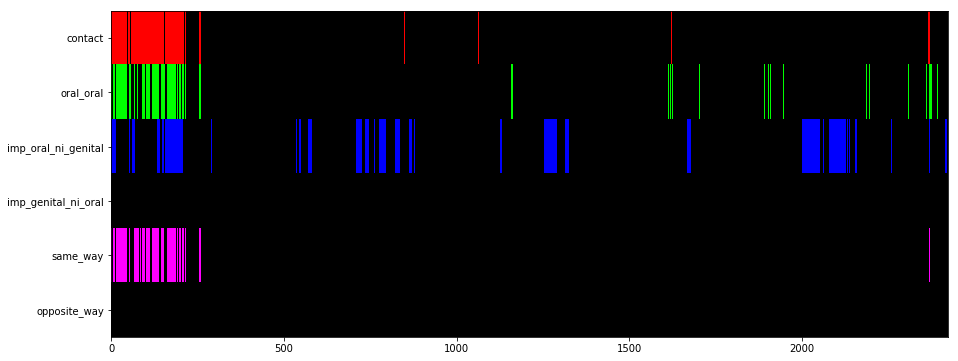

In [11]:
fig = plt.figure(figsize=(15,6))
plt.imshow(data_matrix, aspect='auto')
_ = plt.yticks(np.arange(6), events_list)